In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import pandas as pd
import seaborn as sns
import fiona
import sklearn

from sklearn.model_selection import KFold

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [37]:
#Upload the selection of glacier i will use in the model
selection = []

with open('/Users/francesco/Desktop/Thesis/Data/dataset_filtered' + '/selecao.txt', 'r') as f:
    for line in f:
        selection.append(int(line.strip()))

common_years = np.arange(2005,2017,1)

print('The shape of the selection is: ', np.shape(selection))

The shape of the selection is:  (128,)


In [38]:
#In this block i am exxtracting all the informations fo ice shelfs from the shp file

path_to_tif = '/Users/francesco/Desktop/Data/GEOTIFFs/'
shapefile_path = '/Users/francesco/Desktop//Thesis/Data/ice_shelf.shp'

ids = []
Names = []
regions = []
areas = []
lats = []
lons = []


shapefile=fiona.open(shapefile_path)
print(shapefile.schema['properties'])

for feature in shapefile:

    id = feature['properties']['id']
    name=feature['properties']['name']
    area=feature['properties']['area_fra']
    lat = feature['properties']['latitude']
    lon = feature['properties']['longitude']
    geometry=feature['geometry']
    if geometry is None:
        continue
    region = feature['properties']['regions']

    #Taking the info
    ids.append(id)
    Names.append(name)
    regions.append(region)
    areas.append(area)
    lats.append(lat)
    lons.append(lon)

#Creating the dataframe
df_region = pd.DataFrame(index=ids)
df_region ['id'] = ids
df_region ['Name'] = Names
df_region ['Region'] = regions
df_region ['Area'] = areas
df_region ['Latitude'] = lats
df_region ['Longitude'] = lons

#Selecting the region and sorting the dataframe
df_region = df_region[df_region['id'].isin(selection)]
df_region = df_region.sort_values(by=['id'])
#drop id column
df_region = df_region.drop(['id'], axis=1)


{'id': 'int:10', 'name': 'str:30', 'regions': 'str:11', 'type': 'str:2', 'is_index': 'int:10', 'ice_shelf_': 'str:50', 'measures_n': 'str:50', 'latitude': 'float:24.15', 'longitude': 'float:24.15', 'thickness_': 'float:24.15', 'thicknes_1': 'float:24.15', 'smb_mean_9': 'float:24.15', 'smb_mean_1': 'float:24.15', 'ss_gl_flux': 'float:24.15', 'ss_gl_fl_1': 'float:24.15', 'ss_calving': 'float:24.15', 'ss_calvi_1': 'float:24.15', 'model_gl_f': 'float:24.15', 'instant_co': 'float:24.15', 'mass_loss_': 'float:24.15', 'mass_los_1': 'float:24.15', 'mass_los_2': 'float:24.15', 'mass_los_3': 'float:24.15', 'mass_los_4': 'float:24.15', 'mass_los_5': 'float:24.15', 'mass_los_6': 'float:24.15', 'mass_los_7': 'float:24.15', 'mass_los_8': 'float:24.15', 'mass_los_9': 'float:24.15', 'mass_los10': 'float:24.15', 'mass_los11': 'float:24.15', 'mass_los12': 'float:24.15', 'mass_los13': 'float:24.15', 'mass_los14': 'float:24.15', 'mass_los15': 'float:24.15', 'mass_los16': 'float:24.15', 'mass_los17': 'floa

In [39]:
#Loading the dataset
dataset_directory = '/Users/francesco/Desktop/Thesis/Data/dataset_filtered/'

# Basal Melting
bm = pd.read_csv(dataset_directory + '/bm.csv', index_col=0)
bm = bm.sort_values(by=['id']) #sorting the glaciers by their index
bm = bm.loc[bm.index.isin(selection)] #selecting the glaciers, according to their index
bm = bm[common_years.astype(str)] #selecting the common years
bm = bm.sort_index() #sorting the glaciers by their index

#Load the calving data
calving = pd.read_csv(dataset_directory+ '/df_calving_from_shp_negative_and_positive.csv', index_col=0)
calving = calving.loc[calving.index.isin(selection)]
calving = calving[common_years.astype(str)]
#sort the calving by its index
calving = calving.sort_index()

#Load the ice concentration data
i_c = pd.read_csv(dataset_directory + '/ice_c_avg_extended_front.csv', index_col=0)
i_c = i_c.loc[i_c.index.isin(selection)]
i_c = i_c[common_years.astype(str)]
i_c = i_c.sort_index()

#Load the ice velocity data
i_v = pd.read_csv(dataset_directory + '/velocity_80_percentile_extended_front_2011_2012_linear_trend.csv', index_col=0)
i_v = i_v.loc[i_v.index.isin(selection)]
i_v = i_v[common_years.astype(str)]
i_v = i_v.sort_index()

#Load the ice thickness data
i_t = pd.read_csv(dataset_directory + '/thickness_avg_extended front.csv', index_col=0)
i_t = i_t.loc[i_t.index.isin(selection)]
i_t = i_t[common_years.astype(str)]
i_t = i_t.sort_index()

index = bm.index

In [40]:
#make a dataset with all the variables
dataset = pd.concat([bm, calving, i_c, i_v, i_t], axis=1, keys=['bm', 'calving', 'i_c', 'i_v', 'i_t'])
dataset.columns.names = ['Variables', 'Years']
dataset.index.names = ['Glaciers']


In [41]:
#Folders division

folder_1 = [2,4,6,7,8,15,18,16,34,45,135,163,95]
folder_2 = [3,29,10,12,31,30,19,24,35,50,86,104,139]
folder_3 = [65,43,37,17,41,32,38,40,36,52,143,146,125]
folder_4 = [69,67,63,26,46,33,64,44,70,53,123,145,170]
folder_5 = [75,78,89,39,47,81,77,54,71,55,118,101,117]
folder_6 = [76,80,114,58,48,84,83,66,90,56,140,144,164]
folder_7 = [88,82,120,61,57,92,85,105,100,73,158,124,169]
folder_8 = [96,107,121,62,60,127,87,108,102,91,161,122,160]

cv_folders = [folder_1, folder_2, folder_3, folder_4, folder_5, folder_6, folder_7, folder_8]

folder_9 = [129,112,156,68,97,132,93,109,115,98,148,166] #test
folder_10 = [131,147,157,72,99,136,116,111,119,110,162,159] #test

#merge the folders, in order to have a single list
from itertools import chain

train = [folder_1, folder_2, folder_3, folder_4, folder_5, folder_6, folder_7, folder_8]
test = [folder_9, folder_10]
test = list(chain.from_iterable(test))


In [42]:
#Operate block division
cv_block_1 = dataset.loc[folder_1]
cv_block_2 = dataset.loc[folder_2]
cv_block_3 = dataset.loc[folder_3]
cv_block_4 = dataset.loc[folder_4]
cv_block_5 = dataset.loc[folder_5]
cv_block_6 = dataset.loc[folder_6]
cv_block_7 = dataset.loc[folder_7]
cv_block_8 = dataset.loc[folder_8]

cv_blocks = [cv_block_1, cv_block_2, cv_block_3, cv_block_4, cv_block_5, cv_block_6, cv_block_7, cv_block_8]
test_block = dataset.loc[test]

In [43]:
#merge the blocks, so i will have the training set already ordered according to the blocks
cv = pd.concat(cv_blocks)

#Display option 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
len(cv)

104

Trying now to perform a cross validation, with the "automatic function"

In [44]:
#Just to see how kFold works
from sklearn.model_selection import KFold

X = [[1,2],[3,4],[6,8]]
y = [1,2,3]

kf = KFold(n_splits=3, shuffle=False, random_state=None)
for train_index, test_index in kf.split(X):
    print("Train:", train_index, "Validation:", test_index)


Train: [1 2] Validation: [0]
Train: [0 2] Validation: [1]
Train: [0 1] Validation: [2]


In [49]:
cvl

array([-2126.94278894, -1153.30686513,  -112.67248581,  -416.698946  ,
       -2860.71842483, -6498.10452468,   -95.46561486, -2123.30631494])

In [46]:
#Using the functions. Next blocks should have the same results but without using functions

import importlib
import rf_functions 

importlib.reload(rf_functions)  # Reload the module
from rf_functions import get_rf_best_params

from sklearn.model_selection import cross_val_score




grid = {
    'n_estimators': [10, 50],
    'max_depth': [5,10],
    'min_samples_split': [1, 2],
    'min_samples_leaf': [1, 2],
    'criterion': ['squared_error'],
}

X = cv.drop('calving', axis=1)
y = cv['calving']

cv_split = KFold(n_splits=8, shuffle=False, random_state=None)


max_depth, n_estimators, min_samples_leaf, min_samples_split = get_rf_best_params(X, y, cv_split, grid)


#defining the model with the best parameters
fitter_rf = sklearn.ensemble.RandomForestRegressor(criterion='squared_error',
                                                    max_depth=max_depth,
                                                    n_estimators=n_estimators,
                                                    min_samples_split=min_samples_split,
                                                    min_samples_leaf=min_samples_leaf,
                                                    random_state=42,
                                                    n_jobs=-1
                                                    )

cvl = cross_val_score(fitter_rf, X, y, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1)

print('The mean of the cross validation is: ', np.mean(cvl))
print('The std of the cross validation is: ', np.std(cvl))

Dioporco


/Users/francesco/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
64 fits failed out of a total of 128.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
64 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/francesco/anaconda3/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/francesco/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/Users/francesco/anaconda3/lib/python3.10/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constrain

max_depth:  10
n_estimators:  50
min_samples_leaf:  2
min_samples_split:  2
The mean of the cross validation is:  -1923.4019956484613
The std of the cross validation is:  1980.2509079922552


In the next code block i will perform a Grisd-search and a model tuning accorrding to the block division strategy. The order of the blocks is preserved by Kfold, by not mixing the variables. This was re done with the functions later.

In [61]:
''' 
#defining the grid for the search
grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [5,10,15,20,25,30,35,40,45,50],
    'min_samples_split': [1, 2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5],
    'criterion': ['squared_error'],
}

#defining the model
rf = sklearn.ensemble.RandomForestRegressor(random_state=42, n_jobs=-1)

#Splitting the dataset in 8 blocks, according to the folders division. The shuffle is set to False, in order to have the same division as the one i used for the folders
cv_split = KFold(n_splits=8, shuffle=False, random_state=None)


#Perform the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=grid, cv=cv_split, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error') #lower values are better


#Fitting the model
grid_search.fit(cv.drop(['calving'], axis=1), cv['calving'])


print(grid_search.best_params_)
print(grid_search.best_score_)
'''

Fitting 8 folds for each of 1400 candidates, totalling 11200 fits
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=1, n_estimators=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=5, min_samples_leaf=1,

KeyboardInterrupt: 

In the next cell i will keep records of the results


In [62]:
grid = {
    'n_estimators': [10, 50, 100, 500, 1000],
    'max_depth': [5,10,15,20,25,30,35,40,45,50],
    'min_samples_split': [1, 2, 3, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 3, 5],
    'criterion': ['squared_error'],
}

{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 500}
-1750.2160949671716

-1750.2160949671716

In [12]:

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

cv_split = KFold(n_splits=8, shuffle=False, random_state=None)
rf_fitted = sklearn.ensemble.RandomForestRegressor(criterion='squared_error', 
                                                   max_depth= 5,#grid_search.best_params_['max_depth'], 
                                                   n_estimators=  500,#grid_search.best_params_['n_estimators'],
                                                   min_samples_split= 10,# grid_search.best_params_['min_samples_split'],
                                                   min_samples_leaf= 5,#grid_search.best_params_['min_samples_leaf'],
                                                   random_state=42,
                                                   n_jobs=-1
                                                   )

cvs = cross_val_score(rf_fitted, cv.drop(['calving'], axis=1), cv['calving'], cv=cv_split, scoring='neg_mean_squared_error', n_jobs=-1)

rf_fitted.fit(cv.drop(['calving'], axis=1), cv['calving'])

RandomForestRegressor(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                      n_estimators=500, n_jobs=-1, random_state=42)

In [13]:
print('Cross validation scores per fold: ', cvs)
print('Mean cross validation score: ', cvs.mean())
print('Standard deviation: ', cvs.std())

#plot_prediction_per_fold(X, y, fitted_model, idc_list)

Cross validation scores per fold:  [-2136.27726829  -872.4052544   -107.72849283  -492.92853494
 -1657.13642556 -6523.02859944  -129.31307003 -2082.91111425]
Mean cross validation score:  -1750.2160949671716
Standard deviation:  1959.7368526462917


Cross validation scores per fold:  [-2277.51726151  -958.2659416   -142.88396257  -764.34435281
 -1769.59631356 -6455.15156281  -110.56429227 -2180.08198158]
Mean cross validation score:  -1832.3007085891043
Standard deviation:  1917.5773855003897

In [14]:
#len(rf_fitted.predict(cv.drop('calving', axis=1)))
len(cv['calving'])

104

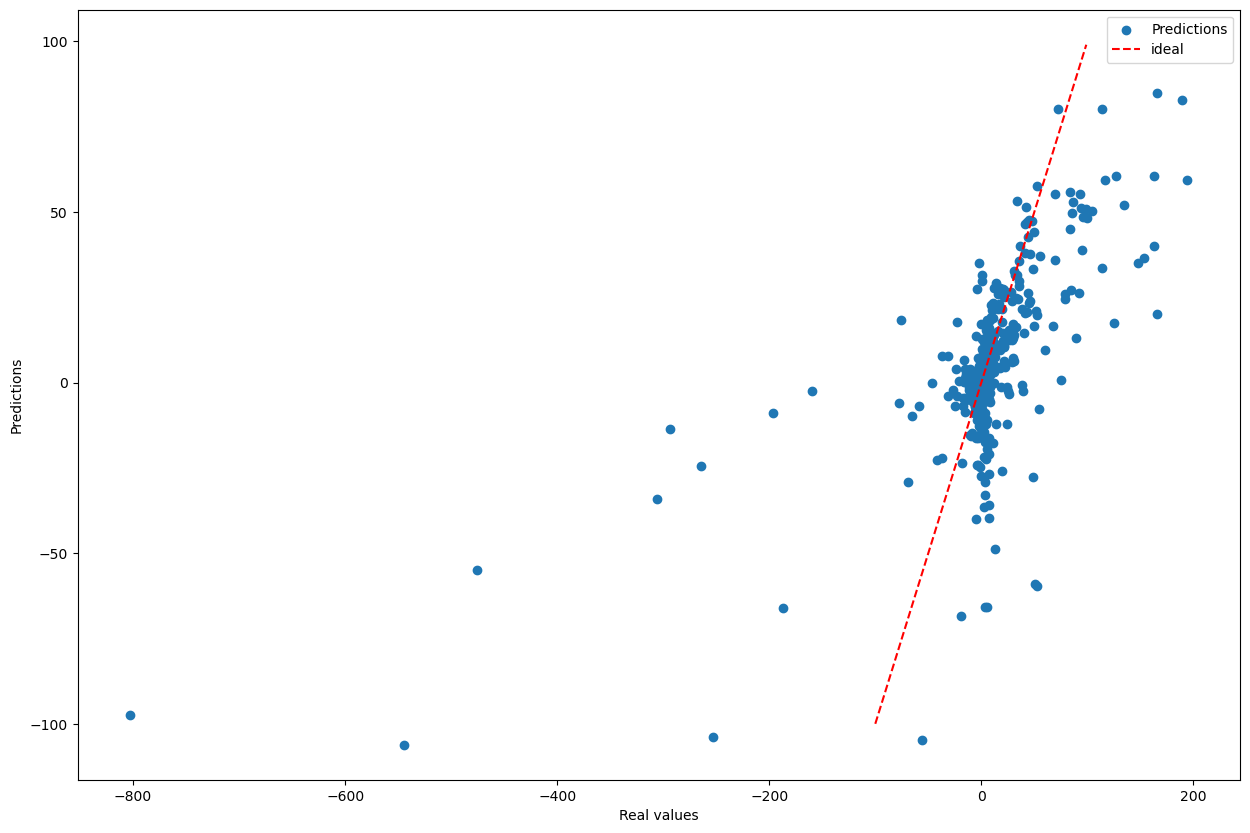

In [15]:
#Plot the predictions against the real values
plt.figure(figsize=(15,10))
plt.scatter(cv['calving'], rf_fitted.predict(cv.drop('calving', axis=1)), label='Predictions')

#labels
plt.xlabel('Real values')
plt.ylabel('Predictions')

#Plot the 1:1 line
plt.plot(np.arange(-100,100), np.arange(-100,100), label='ideal', color='red', linestyle='--')

#Limit the axis
#plt.xlim(-100, 100)
#plt.ylim(-100, 100)


plt.legend()

Experimenting with functions

type: Number of dimensions is greater than number of samples. This results in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Note that `gaussian_kde` interprets each *column* of `dataset` to be a point; consider transposing the input to `dataset`.

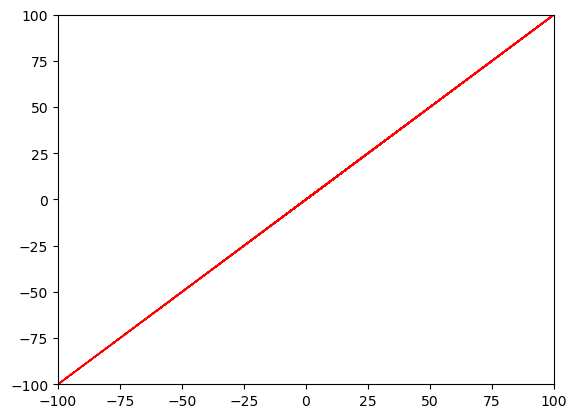

In [22]:
from scipy.stats import gaussian_kde

#plot also the line of the perfect prediction
plt.plot(cv['calving'], cv['calving'], color='red', linewidth=1, linestyle='--')

#Limit the axis to -100, 100
plt.xlim(-100, 100)
plt.ylim(-100, 100)

x = cv['calving']
y = rf_fitted.predict(cv.drop('calving', axis=1))

xy = np.vstack([x,y])

z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100, cmap='viridis')
plt.show()


#cbar = plt.colorbar()
#cbar.set_label('Point Density')

plt.show()



In [ ]:
#plot the prediction per fold

plt.figure(figsize=(20,10))
plt.scatter(cv['calving'],rf_fitted.predict(cv.drop(['calving'])))
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Observed vs Predicted')
plt.show()


type: "['calving'] not found in axis"

<Figure size 2000x1000 with 0 Axes>

In [ ]:
def plot_prediction_per_fold(X, y, model, idc_list):
    """
    Plot model predictions of model vs. test data y based on 
    folds given by indices X_idc and y_idc.
  
    Parameters:
    X : np.array
        Training dataset of features.
    y : np.array
        Labels of training dataset.
    model : sklearn.model
        Fitted XGBmodel object.
    X_idc : np.array
        Indices of fold splits of features.
    y_idc : np.array
        Indices of fold splits for labels.
    """

    y_test_list = []
    y_pred_list = []

    for train_index, test_index in idc_list:
        # Loops over n_splits iterations and gets train and test splits in each fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_test_list.extend(y_test)
        y_pred_list.extend(y_pred)

    # Arrays of predictions and observations for each fold
    y_test_all = np.hstack([*y_test_list])
    y_pred_all = np.hstack([*y_pred_list])

    # Plot predictions and observations for each cross-valiadation fold together
    plot_prediction(y_test_all, y_pred_all, 'Validation', n_toplot=5000)


In the following block i performed (twice) a Random forest grid search, looking for the best hyper-parameters. I did it 'manually', i will now try to re do it with the 
cross validation which is included in the function (previous code blocks)

In [ ]:
# operate cross validation with the block method
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Grid search
'''
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None,2, 5, 10, 20],
    'criterion': ['squared_error', 'absolute_error']
}
'''
grid = {
    'n_estimators': [10,50,100],
    'max_depth': [None,1],
    'criterion': ['squared_error', 'absolute_error']
}

#rf = RandomForestRegressor(n_estimators=1000, random_state=42)
best_parameters = []
mae_scores = []

for i in range(len(cv_blocks)):
    print(f"Fold {i +1 }:")

    #Extracting the training an testing blocks from the list
    validation_block = cv_blocks[i]
    train_blocks = cv_blocks[:i] + cv_blocks[i+1:]

    #Extracting the training and testing variables and targets
    X_test = validation_block.drop(['calving'], axis=1)
    y_test = validation_block['calving']

    X_train = pd.concat(train_blocks).drop(['calving'], axis=1)
    y_train = pd.concat(train_blocks)['calving']

    # Fit the model on the training data
    rf_cv = GridSearchCV(RandomForestRegressor(), grid)

    # Make predictions on the test data
    rf_cv.fit(X_train, y_train)
    y_pred = rf_cv.predict(X_test)

    '''
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')

    #plot the line y= x (diagonal of the first and third quadrant)
    max_value = np.max([y_test, y_pred])
    min_value = np.min([y_test, y_pred])
    x = np.linspace(min_value, max_value, 100)
    plt.plot(x, x, color='black')
    plt.title('Fold ' + str(i+1))


    plt.show()
    '''

    # Evaluate the model's performance
    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    best_parameters.append(rf_cv.best_params_)



Fold 1:


KeyboardInterrupt: 

In [ ]:
mae_scores

[14.941517628205128,
 9.198303205128205,
 3.3142384615384617,
 8.581923076923077,
 13.542544871794872,
 15.390641987179487,
 5.062366666666667,
 10.802583333333333]

In [ ]:
best_parameters

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

In the following block i saved the results fromm the grid search

In [ ]:
#First grid search
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None,2, 5, 10, 20],
    'criterion': ['squared_error', 'absolute_error']
}


#Mae scores
scores_1 = [13.543539246872902,
 7.1936,
 3.0449211538461536,
 7.448460042735043,
 16.490779807692306,
 15.644852350427351,
 5.029717307692307,
 11.763670210811362]


[{'criterion': 'squared_error', 'max_depth': 20, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 300},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 300},
 {'criterion': 'absolute_error', 'max_depth': 2, 'n_estimators': 100},
 {'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 100}]

#Second grid search
grid = {
    'n_estimators': [10,50,100],
    'max_depth': [1,2,5],
    'criterion': ['squared_error', 'absolute_error']
}

#Mae scores

scores_2 = [13.75309294871795,
 8.036669551282051,
 3.2670608974358974,
 10.98667982493302,
 14.47870608974359,
 15.34166474358974,
 4.937871794871795,
 11.16877564102564]

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

[{'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 50},
 {'criterion': 'squared_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 100},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10},
 {'criterion': 'absolute_error', 'max_depth': 1, 'n_estimators': 10}]

In [ ]:
#Here i will use the best parameters found in the grid search to train the model on the entire dataset.
# I will use the weights to give more importance to the glaciers with a lower mae score

#Scores
weights_1 = [1/score for score in scores_1]
weights_2 = [1/score for score in scores_2]
weights_list = weights_1 + weights_2

#n_estimator
n_estimmator_list = [100, 100, 100, 300, 100, 300, 100, 100, 10, 100, 50, 10, 100, 100, 10, 10]
n_estimator_weighted_avg = np.average(n_estimmator_list, weights=weights_list)

#max_depth
max_depth_list = [20, 2, 2, 2, 2, 2, 2, 5, 1, 1, 1, 1, 1, 1, 1, 1]
max_depth_weighted_avg = np.average(max_depth_list, weights=weights_list)


In [ ]:
#Perform random forest with the best parameters on the whole dataset

train_block = cv_blocks

test_block = dataset.loc[test]


#Extracting the training and testing variables and targets
X_test = test_block.drop(['calving'], axis=1)
y_test = test_block['calving']

X_train = pd.concat(train_blocks).drop(['calving'], axis=1)
y_train = pd.concat(train_blocks)['calving']


In [ ]:
#Perform random forest with the best parameters on the whole dataset

rf_optimized = RandomForestRegressor(n_estimators= int(n_estimator_weighted_avg), max_depth=int(max_depth_weighted_avg), criterion='absolute_error', random_state=42)
rf_optimized.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=2, n_estimators=92,
                      random_state=42)

In [ ]:
# Make predictions on the test data
y_pred = rf_optimized.predict(X_test)

# Evaluate the model's performance
mae = mean_absolute_error(y_test, y_pred)
mae

3.3510275135869567

In [ ]:
#perform the cross validation on the blocks
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

#Create the model
model = RandomForestRegressor(n_estimators=1000, random_state=42)


Variables     bm                                                          \
Years       2005   2006   2007   2008   2009   2010   2011   2012   2013   
Glaciers                                                                   
129.0      -0.09   0.06  -0.02   0.05  -0.04  -0.03   0.08  -0.06   0.18   
112.0      -0.46   2.34  -0.59  -0.96   0.47   1.12   0.14   0.19   0.73   
156.0       4.08   4.77   4.31  -3.46   3.43   8.15   3.29   1.91   1.93   
68.0       -0.68   1.14   0.40  -0.81  -0.70  -0.23   0.78  -0.04   0.43   
97.0        1.61   1.62  -0.05   1.39   0.31  -0.65   0.37   2.08   0.21   
132.0       0.02   0.01  -0.01   0.01  -0.02  -0.01   0.00   0.02  -0.01   
93.0        0.03   0.03   0.03   0.03   0.03   0.05   0.02   0.02   0.03   
109.0       0.07  -0.22   0.58   0.57   0.60  -0.33  -0.35   1.47   1.10   
115.0      84.58 -14.66  58.00 -18.95  34.16  35.65  17.26 -19.98  56.60   
98.0       68.66  55.06  45.23  43.88  37.31  63.01  55.79  50.05  39.56   
148.0      -0.01  -0.11   0.18  -0.10  -0.01   0.24  -0.02  -0.07  -0.07   
166.0       0.05  -0.15   0.42   0.47   0.13  -0.02   0.05   0.32   0.11   
131.0       0.01   0.01   0.01   0.00   0.01   0.03   0.05   0.02   0.00   
147.0      -0.77  -0.37  -0.14  -0.29  -0.77  -0.97  -0.73  -0.11  -0.08   
157.0      42.42  22.53  16.22  28.06  29.07  31.24  21.90  25.77  12.21   
72.0        0.23   0.17  -0.16   0.12  -0.02   0.72   0.48   0.22  -0.18   
99.0        3.26   5.26   3.96   1.01   6.34   5.45   6.89   5.30   5.39   
136.0       0.04  -0.04  -0.03   0.06  -0.02  -0.05   0.00  -0.01  -0.02   
116.0      -0.05   0.68  -0.35  -0.74  -0.09  -0.11  -0.54   0.42  -0.50   
111.0      -0.85   0.69  -0.10   0.31   0.23   0.84   0.16   1.17   0.27   
119.0      11.13   6.66  -5.28   3.35 -12.62 -24.59   2.42  11.62  -0.35   
110.0      39.47  37.23  63.71  61.06  52.19  57.64  15.49  76.08  69.87   
162.0      -8.80 -11.24  -3.71  -9.21 -13.03  -9.52 -14.20  -7.82 -10.28   
159.0       3.86   4.65   6.12   5.62   4.86   4.76   3.89   5.14   4.16   

Variables         ...         i_t                                      \
Years       2014  ...        2007        2008        2009        2010   
Glaciers          ...                                                   
129.0       0.06  ...  180.866100  180.866100  180.866100  180.866100   
112.0       0.83  ...  319.478700  321.908050  324.552980  321.090700   
156.0      -0.25  ...  418.564120  417.277920  417.449650  412.953060   
68.0        0.62  ...  268.352720  271.821780  272.244800  273.989930   
97.0       -0.34  ...  161.705860  159.282930  158.537860  161.806270   
132.0      -0.01  ...  373.000700  373.438500  374.815220  375.903350   
93.0        0.02  ...  462.250180  462.250180  462.250180  462.250180   
109.0       1.09  ...   72.793724   72.289670   71.069740   71.580864   
115.0      29.35  ...  251.033520  250.041950  250.724010  250.222290   
98.0       30.45  ...  316.083830  315.548740  317.109130  317.873100   
148.0       0.19  ...  327.493070  327.973020  329.060100  322.963620   
166.0       0.37  ...  249.199810  240.614580  228.101140  230.941350   
131.0       0.01  ...  274.698060  274.698060  274.698060  274.698060   
147.0      -0.56  ...  390.174200  388.436250  388.732540  392.510800   
157.0      17.03  ...  393.902500  394.683960  393.702100  393.447450   
72.0        0.32  ...  307.582820  308.068330  308.317630  306.189940   
99.0        4.75  ...  123.890210  124.807495  123.971306  123.258370   
136.0      -0.01  ...   62.414383   85.350950   65.758750   77.580570   
116.0      -0.72  ...  574.245060  577.602660  588.348200  585.908450   
111.0       0.90  ...   75.225190   74.918430   76.030160   72.865800   
119.0       1.72  ...  218.226440  218.006180  219.213680  222.004440   
110.0      63.93  ...  132.660500  131.102750  129.797640  128.593550   
162.0      -6.86  ...  529.081400  524.883670  527.382750  528.037900   
159.0       3.67  ...  299.772280  296.261870  29

In [ ]:
#Scalarization.Should i do it? Probably not, since Random Forest is not very sensitive to the magnitude of the variables

''' 
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
np.shape(X_train_scaled)
'''

' \nfrom sklearn.preprocessing import StandardScaler\nstd_scaler = StandardScaler()\n\nX_train_scaled = std_scaler.fit_transform(X_train)\nnp.shape(X_train_scaled)\n'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#Initialise the model
rf = RandomForestRegressor(random_state=42)

#Set a grid of parameters
param_grid = {
    'n_estimators': [100, 500, 1000, 1500], 
    'max_leaf_nodes': [None, 16, 32, 64], 
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

#Fit the grid to the training data
grid_search.fit(X_train, y_train)

#Print the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)


#Training the model
#rf.fit(X_train, y_train)

{'max_leaf_nodes': None, 'n_estimators': 500}
-3.1129931969608013


In [ ]:
beast_max_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
beast_n_estimators = grid_search.best_params_['n_estimators']

best_rf = RandomForestRegressor(max_leaf_nodes=beast_max_leaf_nodes, n_estimators=beast_n_estimators, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=42)

In [ ]:
predictions = best_rf.predict(X_test)

In [ ]:
from pprint import pprint

print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [ ]:
#Evaluating the model
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


#Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

#Visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#Plotting the predictions
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#Plotting the residuals
plt.scatter(predictions, y_test-predictions)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

MAE: 4.9132847008547005
MSE: 137.19971786560686
RMSE: 11.713228328074496


type: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
#Now i want to create a dataset, which contains the predictions, and their respective index, which is the glacier id of the y_test
df_predictions = pd.DataFrame(index=y_test.index, columns= common_years)

i = 0
for id in y_test.index:
    df_predictions.loc[id] = predictions[i]
    i = i + 1
i=0

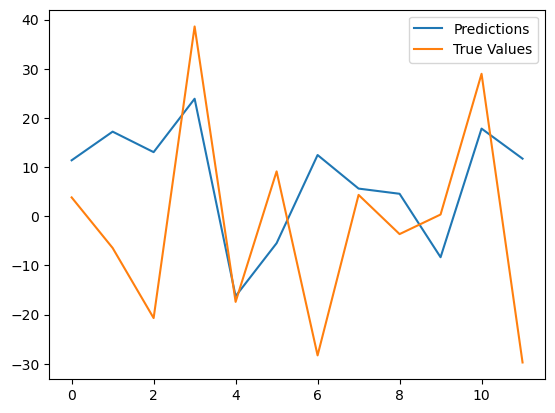

In [ ]:
id = 98


#Plot both the predictions and the y_train.iloc[0].values

plt.plot(df_predictions.loc[id].values)
plt.plot(y_test.loc[id].values)

#Add legend and title
plt.legend(['Predictions', 'True Values'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE: 4.94559829059829
MSE: 138.63969305435896
RMSE: 11.774535789336197


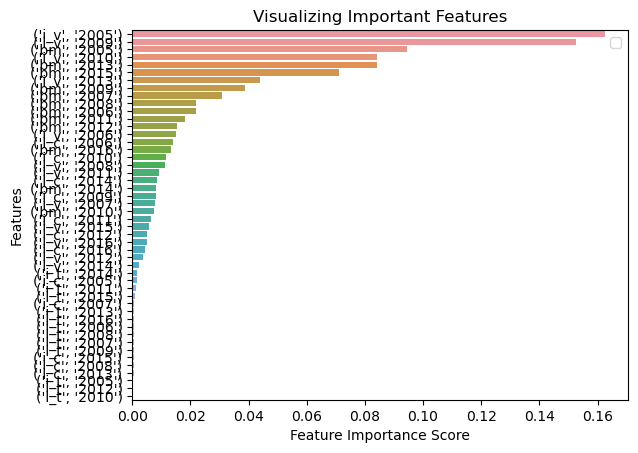

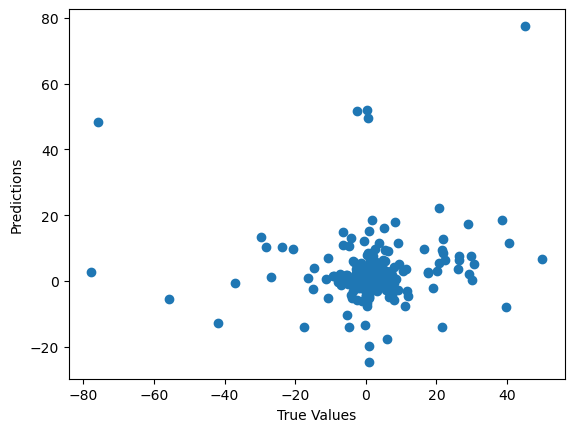

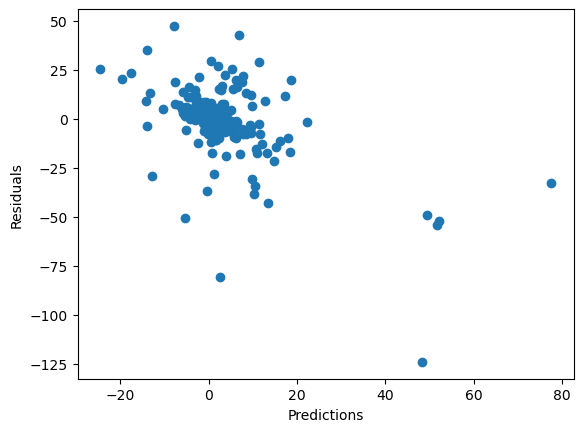

In [ ]:
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)

#Evaluating the model
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


#Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

#Visualize the feature importance
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

#Plotting the predictions
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

#Plotting the residuals
plt.scatter(predictions, y_test-predictions)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()



In [ ]:
np.shape(y_test)
np.shape(predictions)

(39, 12)

In [ ]:
np.shape(y_test)

(39, 12)

In [ ]:
y_test

Years,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Glaciers,,,,,,,,,,,,
73.0,-7.02,-11.25,-16.40,6.66,-2.32,1.84,0.48,3.07,2.54,0.50,-5.30,1.16
57.0,26.40,9.53,4.70,8.54,7.30,-55.77,3.33,2.14,3.94,-37.14,-0.57,8.13
33.0,0.36,-1.48,2.82,-3.12,-1.35,0.99,0.67,0.70,0.57,-0.45,0.27,0.33
46.0,0.16,0.69,0.59,-1.43,-4.70,0.82,-2.67,-0.81,-2.80,-5.24,-2.76,-0.03
122.0,0.76,0.84,0.58,1.13,0.16,0.65,0.86,0.59,0.81,-0.02,-1.57,-0.02
75.0,0.03,0.00,0.02,0.12,-0.15,0.02,-0.11,0.02,0.02,0.03,-0.66,-0.22
89.0,2.94,1.28,0.62,0.31,-3.77,2.88,1.33,1.52,2.78,3.20,1.59,2.56
131.0,-0.03,-0.03,0.03,0.00,0.00,-0.50,-0.02,0.01,-0.01,-0.01,-0.03,0.08
102.0,40.55,21.72,29.79,49.92,11.71,5.20,16.38,21.71,9.02,-77.74,-6.35,21.83


In [ ]:
#Create a dataset with the predictions, the true values and the respective index (glacier identifier)
df_predictions = pd.DataFrame(index=y_test.index, columns=['Predictions'])
df_predictions['Predictions'] = predictions

df_true_values = pd.DataFrame(index=y_test.index, columns=['True Values'])
#df_true_values['True Values'] = y_test

In [ ]:
#Now i want to perform the cross validation to find the best parameters for the model i will implement, whic is Random Forest
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor

param_grid = [
    {'n_estimators': [3, 10, 30, 50, 100, 200, 300, 400, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 30, 50, 100, 200, 300, 400, 500], 'max_features': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]},
  ]

forest_reg = RandomForestRegressor()
